In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

import interval_regression

# Recovering true coefficients on artificially censored regression data

Data construction

In [2]:
n_sample = 1000
noise = 5.0
intercept = 3.14
n_features = 1
x, y_orig, coef = make_regression(
    n_samples=n_sample, n_features=n_features, coef=True, noise=noise, random_state=np.random.RandomState(seed=42)
)
y_orig = y_orig + intercept
print(f"coef={coef}, noise={noise}, intercept={intercept}")

coef=16.748258225906977, noise=5.0, intercept=3.14


## Interval construction

In [3]:
bounds = [None, -100, -75, -50, -25, -10, -5, 0, 5, 10, 25, 50, 75, 100, None]
intervals = {
    index: (lower_bound, upper_bound)
    for index, (lower_bound, upper_bound) in enumerate(zip(bounds, bounds[1:]))
}

In [4]:
from interval_regression import get_index_vector
y_index = get_index_vector(y_orig, intervals)

## Using the module to solve the problem

In [5]:
interval_model = interval_regression.IntervalModel()
result = interval_model.fit(x, y_index, intervals)

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 926.8657626985124
 message: 'Optimization terminated successfully.'
    nfev: 33
     nit: 1
  status: 0
 success: True
       x: array([ 3.16089315, 16.57806053,  4.7843    ])


## Plotting

In [6]:
y_prediction = result.ols_predict(x)
intervals_min = {index: lower_bound for index, (lower_bound, _upper_bound) in intervals.items()}
get_minpoints = np.vectorize(intervals_min.get)
y_censured = get_minpoints(y_index)

In [7]:
plt.scatter(x, y_censured, color = 'darkblue')
plt.scatter(x, y_prediction, color = 'green')
plt.title("Regression on midpoints")

Text(0.5, 1.0, 'Regression on midpoints')

Text(0.5, 1.0, 'Does fit reasonably well the data uncensored')

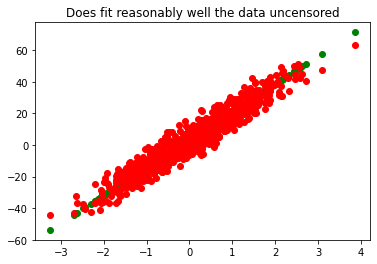

In [7]:
plt.scatter(x, y_prediction, color = 'green')
plt.scatter(x, y_orig, color = 'red')
plt.title("Does fit reasonably well the data uncensored")

Text(0.5, 1.0, 'Censored regression fits a bit better')

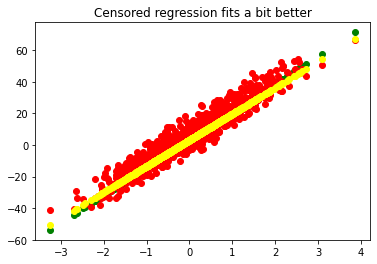

In [8]:
plt.scatter(x, y_prediction, color = 'green')
plt.scatter(x, y_orig + intercept, color = 'red')
plt.scatter(x, result.coef_ * x + result.intercept_, color = 'yellow')
plt.title("Censored regression fits a bit better")

In [9]:
print(f"""
coef={coef}, noise={noise}, intercept={intercept}
ols_coef={result.ols_coef_}, ols_noise={result.ols_sigma}, ols_intercept={result.ols_intercept}
coef={result.coef_}, noise={result.sigma_}, intercept={result.intercept_}
""")


coef=16.748258225906977, noise=5.0, intercept=3.14
ols_coef=[17.64628117], ols_noise=6.513768363012059, ols_intercept=3.4188611073702293
coef=[16.57806053], noise=4.784300004189966, intercept=3.160893151846509



We managed to recover values that are pretty close to the original ones

# Censor regression when the gaussian noise is on the coefficients

## Data construction
I try to simulate real-world data

In [10]:
rg = np.random.default_rng(42)
n_sample = 1000
mu, noise = 110, 30 # mean and standard deviation
coef = mu
intercept = 3.14
# we do a max because we only have positive values
coefficient_with_gaussian_noise = np.maximum(rg.normal(mu, noise, n_sample), 0.1)

I want my data spread accross multiple orders of magnitude. I choose to take the exp10 of a lognormal to do that

In [11]:
# building the x with a great spread 
log_x = rg.lognormal(1, 0.5, n_sample)
x_orig = np.power(10, log_x)
y_orig = np.multiply(x_orig,coefficient_with_gaussian_noise) + intercept
x = x_orig.reshape(x_orig.shape[0], 1)
print(f"coef={coef}, noise={noise}, intercept={intercept}")

coef=110, noise=30, intercept=3.14


In [12]:
bounds = [None] + [unit*10**exposant for exposant in range(12) for unit in {1,5}] + [None]
intervals = {
    index: (lower_bound, upper_bound)
    for index, (lower_bound, upper_bound) in enumerate(zip(bounds, bounds[1:]))
}

In [13]:
from interval_regression import get_index_vector
y_index = get_index_vector(y_orig, intervals)

## Results

In [14]:
interval_model = interval_regression.IntervalModel()
result = interval_model.fit(x, y_index, intervals, alternative_fit=False)

 final_simplex: (array([[ 3580.14420348,   104.41139958, 21535.03472008],
       [ 3580.14423305,   104.41139957, 21535.0347132 ],
       [ 3580.14413995,   104.41139957, 21535.03466688],
       [ 3580.14425355,   104.41139957, 21535.03475495]]), array([2398.67395932, 2398.67395932, 2398.67395932, 2398.67395933]))
           fun: 2398.6739593175917
       message: 'Optimization terminated successfully.'
          nfev: 176
           nit: 81
        status: 0
       success: True
             x: array([ 3580.14420348,   104.41139958, 21535.03472008])


In [15]:
intervals_min = {index: lower_bound for index, (lower_bound, _upper_bound) in intervals.items()}
get_minpoints = np.vectorize(intervals_min.get)
y_censured = get_minpoints(y_index)
y_prediction = result.ols_predict(x_orig)

In [16]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(x ,y_censured , c='blue',edgecolors='none')
ax.scatter(x, y_prediction, color = 'green')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Linear regression is really bad here')

Text(0.5, 1.0, 'Linear regression is really bad here')

OLS regression is really bad here, considering the various order of magnitudes. So our starting points are consequently very bad. We will do an OLS on the log of x and y instead.
Then we will optimize on the coefficient (look at the math notebook to see the difference)

In [17]:
interval_model = interval_regression.IntervalModel()
result = interval_model.fit(x, y_index, intervals, alternative_fit=True)

 final_simplex: (array([[ 20.90887808, 109.88314267,  31.65139703],
       [ 20.9087968 , 109.88314212,  31.65139692],
       [ 20.90885589, 109.88313973,  31.65139704],
       [ 20.90885144, 109.88314348,  31.65139915]]), array([489.52188945, 489.52188945, 489.52188945, 489.52188945]))
           fun: 489.5218894541289
       message: 'Optimization terminated successfully.'
          nfev: 133
           nit: 72
        status: 0
       success: True
             x: array([ 20.90887808, 109.88314267,  31.65139703])


In [18]:
intervals_min = {index: lower_bound for index, (lower_bound, _upper_bound) in intervals.items()}
get_minpoints = np.vectorize(intervals_min.get)
y_censured = get_minpoints(y_index)
y_prediction = result.ols_predict(x_orig)

Text(0.5, 1.0, "It's still off the mark (by a factor ~25), but clearly not as bad")

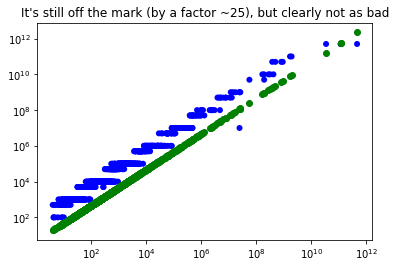

In [19]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(x ,y_censured , c='blue',edgecolors='none')
ax.scatter(x, y_prediction, color = 'green')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("It's still off the mark (by a factor ~25), but clearly not as bad")

Text(0.5, 1.0, 'Does as expected on the data uncensored')

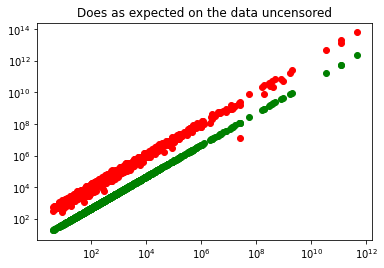

In [20]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(x_orig, y_prediction, color = 'green')
ax.scatter(x_orig, y_orig, color = 'red')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("Does as expected on the data uncensored")

In [21]:
fig = plt.figure()
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(x_orig, y_prediction, color = 'green')
ax.scatter(x_orig, y_orig + intercept, color = 'red')
ax.scatter(x_orig, result.coef_ * x_orig + result.intercept_, color = 'yellow')
plt.title("Censored regression fits a lot better")

Text(0.5, 1.0, 'Censored regression fits a lot better')

In [22]:
print(f"""
coef={coef}, noise={noise}, intercept={intercept}
ols_coef={result.ols_coef_}, ols_noise={result.ols_sigma}, ols_intercept={result.ols_intercept}
coef={result.coef_}, noise={result.sigma_}, intercept={result.intercept_}
""")


coef=110, noise=30, intercept=3.14
ols_coef=[4.70385822], ols_noise=97493.11169315706, ols_intercept=1.0
coef=[109.88314267], noise=31.651397032613875, intercept=20.908878082207508



Intercept is not good, but it is hard to get right considering the orders of magnitudes in the data :)